# Set the random seed for Numpy and Tensorflow, ensures reproducibility of
   1. __*simulated data*__: Signal parameters and add background noise levels are randomly selected.
   2. __*deep clustering model training*__: Starting from the same seed ensures that training differences are due to data or model architecture. For statistical robustness, many models can be trained with different seeds to ensure consistent results.

In [1]:
# set the random seed for Numpy
from numpy.random import seed as rng
rng(2000)
import tensorflow as tf
print(tf.__version__)

# Set the tensorflow random seed. This ensures repeatable training!
#from tensorflow.random import random
tf.random.set_seed(2000)

2.1.0


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]=""
#gpus = tf.config.experimental.list_physical_devices('XLA_GPU')
#print(gpus)

# Fix the preallocated GPU memory fraction to avoid swamping memory.

In [3]:
# Fix the fraction of memory used. This is important if you're sharing GPUs and to avoid over-preallocation.
tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.8)

per_process_gpu_memory_fraction: 0.8

In [4]:
#tf.config.gpu.set_per_process_memory_fraction(0.8)
#gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.8)
#sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

#if gpus:
#    print(gpus[0])
#    tf.config.experimental.set_virtual_device_configuration(gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)])
#    logical_gpus = tf.config.experimental.list_logical_devices('XLA_GPU')
#    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")

In [5]:
print(tf.__version__)
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

# import the package dependencies
import numpy as np # number computation package
import time # for calculating runtime
import scipy.io as sio
import matplotlib.pyplot as plt
from keras.callbacks import TensorBoard
import scipy
print(scipy.__version__)
import scipy.stats as stat

2.1.0
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6559378714178708872
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3042128692
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4606504044463228193
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


Using TensorFlow backend.


1.5.2


# Load packages for signal processing and clustering from Scipy, Scikit-Learn, and my own spectrogram script.

In [6]:
from scipy.signal import find_peaks, hilbert, medfilt
from spect_dB import spect_dB # my spectrogram code

# clustering
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn import metrics

In [7]:
# #
import numpy.random as rd

import importlib
import math

# # # # # # # # s# # #
t00= time.time()

# Run an external Python code to set the input parameters. 

In [8]:
%run set_params_sim.py

## Define functions 

In [9]:
def addnoise(power,snr):
    import numpy as np
    sigma = np.sqrt(power/(10**(snr/10)))
    
    return sigma

def fishy(fc,dt,N,offset,tau,Fs,snrdb,seed):
    import numpy as np
    tmax = np.maximum((offset+N*tau+(N-1)*dt), 2*maxlen)
    t = np.arange(0,tmax,1/Fs)
    a = 2*np.log(2)/(tau**2)
    
    x=0
    rng(seed)
    iphase = rd.rand(1)
    for ii in np.arange(N):
        x = x+np.sin(-2*np.pi*(fc*(t-dt*ii-offset)+iphase))*np.exp(-a*(t-dt*ii-offset)**2)
    
    # optional normalize
    x = x/np.max(np.abs(x[:]))#*6.9

    # add noise
    I1 = int(np.round((offset-2*tau)*Fs))
    I2 = int(np.round((offset+2*tau)*Fs))
    fn =0.0264/.45 # found from single pulse
    if snrdb=='none':
        sigma=0
    else:
        sigma=addnoise(fn,snrdb)
    rng(seed)
    xn = x+sigma*rd.randn(x.shape[-1])
    
    return t,x,xn,fn

def whaley(f0,df,offset,T,Fs,snrdb,seed):
    import numpy as np
    tmax = np.maximum((offset+T), 2*maxlen)
    t = np.arange(0,tmax, 1/Fs)
    delta = (t>offset)*(t<(offset+T))
    rng(seed)
    x = delta*np.sin(-2*np.pi*(df/(T**2)/3*(t-offset)**3 + f0*(t-offset) + rd.rand(1)))
    
    # optional normalize
    x = x/np.max(np.abs(x[:]))
    
    I1 = int(np.round(offset*Fs))
    I2 = int(np.round((offset+T)*Fs))
    if I1<0:# if negative offset (cut off signal at beginning)
        I1=0
    fn = np.sqrt(np.mean(np.abs(x[I1:I2])**2))/.25
    if snrdb=='none':
        sigma=0
    else:
        sigma=addnoise(fn,snrdb)
    rng(seed)
    xn = x+sigma*rd.randn(x.shape[-1])
    
    return t,x,xn,fn

def target_distribution(q):
    """
    Compute the target distribution p, given soft assignements, q. The target distribtuion is generated by giving
    more weight to 'high confidence' samples - those with a higher probability of being a signed to a certain cluster. 
    This is used in the KL-divergence loss function.
    # Arguments
        q: Soft assignement probabilities - Probabilities of each sample being assigned to each cluster.
    # Input:
         2D tensor of shape [n_samples, n_features].
    # Output:
        2D tensor of shape [n_samples, n_features].
    """
    weight = q ** 2 / q.sum(0)
   # print(q.sum(0), weight.sum(1))
    return (weight.T / weight.sum(1)).T

def multiclass_accuracy(predlabels, labels):
    newlab = 100*np.ones(predlabels.shape)
    tlab= np.unique(labels)
    plab = np.unique(predlabels)
    plab_unused = plab.tolist()
    for i in tlab:
        I = np.where(labels==i)[0]
        ac = []
        for j in plab:
            J = np.where(predlabels==j)[0]
            ac.append(np.sum(np.in1d(I,J, assume_unique=True))) #look for where they occur at the same location
        if not plab_unused:
            print('That is all the predicted classes.')
            print(np.unique(newlab))
            break
        else:
            if len(plab)==1:
                newlab = predlabels
                print('Only a single class was detected. Clustering has failed. Returning.')
                break
            switch = np.argmax(np.array(ac)[plab_unused])
            newlab[predlabels==plab_unused[switch]] = i
            plab_unused.remove(plab_unused[switch])
      
              
    return newlab
                
            

## Set parameters

In [10]:
rng(3)
sigparams = dict()
    
Nsamp = 10000

# # CPU !!! # #
Nsamp = 100

Ntrials = 1
Nsamp1 = int(np.floor(np.round(Nsamp*0.5)))
Nsamp2 = Nsamp-Nsamp1#Nsamp-
Nsamp3 = Nsamp-Nsamp1-Nsamp2
print(Nsamp1,Nsamp2,Nsamp3)
seeds_all = rd.permutation(Nsamp*Ntrials)
seeds_all = np.reshape(seeds_all, (Nsamp,Ntrials)) 
snrdb_fish_list = rd.randint(0,high=30,size=Nsamp)#rd.randint(15,high=30,size=Nsamp)
snrdb_whale_list = rd.randint(15,high=30,size=Nsamp)#rd.randint(15,high=30,size=Nsamp)
nclus_list = [2]#,3,4,5,6,7,8,9,10]
ndim_list = [10]#5,6,7,8,9,10,11,12,13,14,15,20,25]
npretrain_list = [1000]#8000,9000,10000]

adjust_fish = 0.3 # seconds, offset to center fish peaks
list_adjust_fish = [0]#, 0.2, 0.3, 0.4]
print(nF)

iex = [4222,9222] # example indices to save, save the TS from these
save_out = dict() # preallocate saveout dictionary (for MATLAB plotting)

# # CPU !!! # #
iex = [22, 72]

50 50 0
90


## Generate Data

In [11]:
data = []
true_labels = []
save_out['xn'] = []
save_out['t'] = []
save_out['fish_params'] = []
save_out['whale_params'] = []
save_out['both_params'] = []

features = {'peakfreq','kurtosis','npeaks'}
pfeatures = dict()
pfeatures['whale'] = dict([(key, []) for key in features])
pfeatures['fish'] = dict([(key, []) for key in features])
pfeatures['both'] = dict([(key, []) for key in features])

Ndata=1
t0=time.time()
for M in range(Ndata):
    input_matrix = np.zeros((Nsamp, nF, nL+1))
    
    seeds = seeds_all[:,0] # Use same seed for repeatability!
    adjust_fish = list_adjust_fish[0]

    ##Simulate whales
    for jj in range(Nsamp1):
        sigparams['snrdb'] = snrdb_whale_list[jj]
        rng(seeds[jj])
        sigparams['T'] = 0.2*(rd.rand(1)+1) #(0.2,0.4) seconds
        sigparams['offset'] = (0.5-sigparams['T'])/2+0.2*rd.rand(1)-0.1#0.25*rd.rand(1) # (0,0.25) seconds
        sigparams['f0'] = 300*rd.rand(1)+100 #(100,400) Hz
        sigparams['df'] = 300*rd.rand(1)-150#+75 # (0,150) Hz
        f1 = sigparams['f0']+sigparams['df']
        t,x,xn,fn = whaley(sigparams['f0'],sigparams['df'],sigparams['offset'],\
                        sigparams['T'],Fs,sigparams['snrdb'],seeds[jj])
        dummy, P1, F1, T1 = spect_dB( xn, Fs, nfft, ovlap ) 
        P1 = P1[(F1>100)*(F1<450), :]
        P1 = P1[:,T1<(T1[0]+maxlen)]
        F1 = F1[(F1>100)*(F1<450)]
        T1 = T1[T1<(T1[0]+maxlen)]

        # optional normalize
        P1 = P1/np.max(np.abs(P1[:]))
        
        # get physical features
        I = np.unravel_index(P1.argmax(), P1.shape)
        pfeatures['whale']['peakfreq'].append(F1[I[0]])
        pfeatures['whale']['kurtosis'].append(stat.kurtosis(xn))
        hil = np.abs(hilbert(xn))
        MPP = 10**(5/10)*np.std(xn)
        pks, prop = find_peaks(hil, prominence=MPP)
        pfeatures['whale']['npeaks'].append(len(pks))
            
        input_matrix[jj,:,:] = 20*np.log10(np.abs(P1))#-np.mean(20*np.log10(np.abs(P1)))
    #    if (jj in iex):
        save_out['t'].append(t)
        save_out['xn'].append(xn)
        save_out['whale_params'].append(sigparams.copy())
           # print(sigparams['snrdb'])
            
    ##Simulate fish
    sdt=0
    for kk in range(Nsamp2):
        mm=kk+Nsamp1
        sigparams['snrdb'] = snrdb_fish_list[mm]
        rng(seeds[mm])
        sigparams['tau']=0.005 #seconds, fixed pulse length
        sigparams['fc'] = 200 # Hz, fixed pulse center freq.
        sigparams['dt'] = 0.47*rd.beta(4,23,size=None) #seconds, spacing (0.06*rand(1)+0.04)
        sdt=sdt+sigparams['dt']
        sigparams['N'] = np.floor(13*rd.beta(3.5,8,size=None)) #int, pulses (randi(6,1,1))
        sigparams['offset'] = 0.35-2*sigparams['tau']-0.5*(sigparams['N']-1)*sigparams['dt']+ (0.2)*rd.rand(1)-0.1 #adjust_fish # seconds, adjusted to center pulse

        if sigparams['N']==0: # can't have 0 pulses
            sigparams['N']=1
        t,x,xn,fn = fishy(sigparams['fc'], sigparams['dt'], sigparams['N'],\
                       sigparams['offset'], sigparams['tau'], Fs, sigparams['snrdb'], seeds[mm])
        dummy, P2, F2, T2 = spect_dB( xn, Fs, nfft, ovlap )
        P2 = P2[(F2>100)*(F2<450), :]
        P2 = P2[:,T2<(T2[0]+maxlen)]
        F2 = F2[(F2>100)*(F2<450)]
        T2 = T2[T2<(T2[0]+maxlen)]

        #optional normalize
        P2 = P2/np.max(P2[:])
        
        # get physical features
        I = np.unravel_index(P2.argmax(), P2.shape)
        pfeatures['fish']['peakfreq'].append(F1[I[0]])
        pfeatures['fish']['kurtosis'].append(stat.kurtosis(xn))
        hil = np.abs(hilbert(xn))
        MPP = 10**(5/10)*np.std(xn)
        pks, prop = find_peaks(hil, prominence=MPP)
        pfeatures['fish']['npeaks'].append(len(pks))

        input_matrix[mm,:,:] = 20*np.log10(np.abs(P2))#-np.mean(20*np.log10(np.abs(P2)))
      #  if (mm in iex):
        save_out['t'].append(t)
        save_out['xn'].append(xn)
        save_out['fish_params'].append(sigparams.copy())
         #   print(sigparams['snrdb'])
            
   ##Simulate fish and whales
    sdt=0
    for kk in range(Nsamp3):
        mm=kk+Nsamp1+Nsamp2
        sigparams['snrdb'] = snrdb_whale_list[jj]
        rng(seeds[mm])
        sigparams['T'] = 0.2*(rd.rand(1)+1) #(0.2,0.4) seconds
        sigparams['offset'] = (0.5-sigparams['T'])/2+0.2*rd.rand(1)-0.1#0.25*rd.rand(1) # (0,0.25) seconds
        sigparams['f0'] = 200*rd.rand(1)+100 #(100,300) Hz
        sigparams['df'] = 150*rd.rand(1)#+75 # (0,150) Hz
        f1 = sigparams['f0']+sigparams['df']
        t,x,x1n,fnw = whaley(sigparams['f0'],sigparams['df'],sigparams['offset'],\
                        sigparams['T'],Fs,sigparams['snrdb'],seeds[mm])
        dummy, P1, F1, T1 = spect_dB( xn, Fs, nfft, ovlap ) 

            
       # sigparams['snrdb'] = #snrdb_list[mm]
        rng(seeds[mm])
        sigparams['tau']=0.005 #seconds, fixed pulse length
        sigparams['fc'] = 200 # Hz, fixed pulse center freq.
        sigparams['dt'] = 0.47*rd.beta(4,23,size=None) #seconds, spacing (0.06*rand(1)+0.04)
        sdt=sdt+sigparams['dt']
        sigparams['N'] = np.floor(13*rd.beta(3.5,8,size=None)) #int, pulses (randi(6,1,1))
        sigparams['offset'] = 0.35-2*sigparams['tau']-0.5*(sigparams['N']-1)*sigparams['dt']+ (0.2)*rd.rand(1)-0.1 #adjust_fish # seconds, adjusted to center pulse

        if sigparams['N']==0: # can't have 0 pulses
            sigparams['N']=1
        t,x,x2n,fnf = fishy(sigparams['fc'], sigparams['dt'], sigparams['N'],\
                       sigparams['offset'], sigparams['tau'], Fs, 'none', seeds[mm])
        
        rng(seeds[mm])
        relevmax = 6.9#np.sqrt(fnw/fnf)
        relev = 0.5*relevmax*rd.rand(1) + relevmax*0.5
        #print(relev)
        xn = x1n + relev*x2n
        
        dummy, P2, F2, T2 = spect_dB( xn, Fs, nfft, ovlap )
        P2 = P2[(F2>100)*(F2<450), :]
        P2 = P2[:,T2<(T2[0]+maxlen)]
        F2 = F2[(F2>100)*(F2<450)]
        T2 = T2[T2<(T2[0]+maxlen)]

        #optional normalize
        P2 = P2/np.max(P2[:])
        
        # get physical features
        I = np.unravel_index(P2.argmax(), P2.shape)
        pfeatures['both']['peakfreq'].append(F1[I[0]])
        pfeatures['both']['kurtosis'].append(stat.kurtosis(xn))
        hil = np.abs(hilbert(xn))
        MPP = 10**(5/10)*np.std(xn)
        pks, prop = find_peaks(hil, prominence=MPP)
        pfeatures['both']['npeaks'].append(len(pks))

        input_matrix[mm,:,:] = 20*np.log10(np.abs(P2))#-np.mean(20*np.log10(np.abs(P2)))
      #  if (mm in iex):
        save_out['t'].append(t)
        save_out['xn'].append(xn)
        save_out['both_params'].append(sigparams.copy())
         #   print(sigparams['snrdb'])

    data.append(input_matrix)
    true_labels.append(np.concatenate((np.zeros(Nsamp1,), np.ones(Nsamp2,), 2*np.ones(Nsamp3,))))
    
print('Generating ' + str(Nsamp*Ntrials) + ' samples takes ' + "{:.4}".format(time.time()-t0) + ' seconds.')

Generating 100 samples takes 0.4327 seconds.


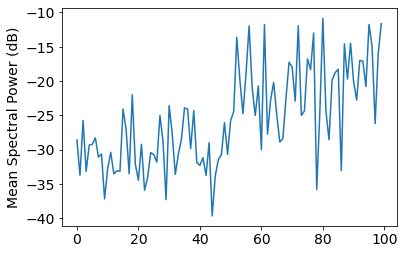

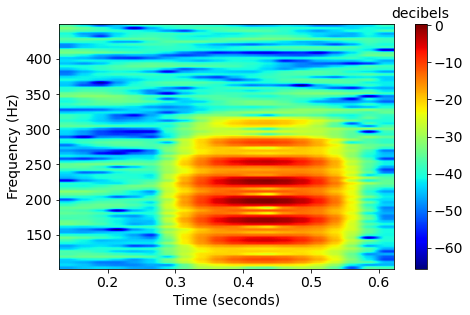

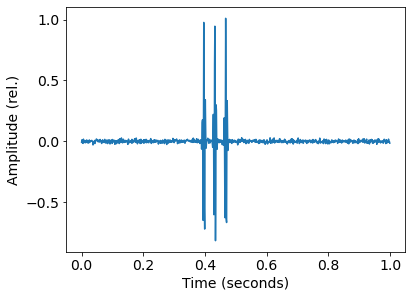

2


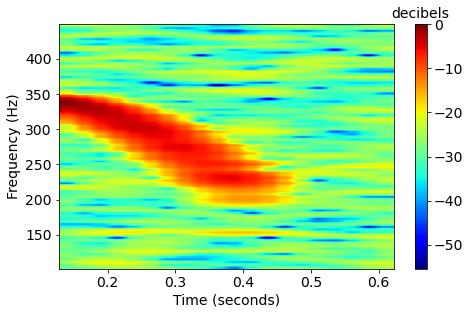

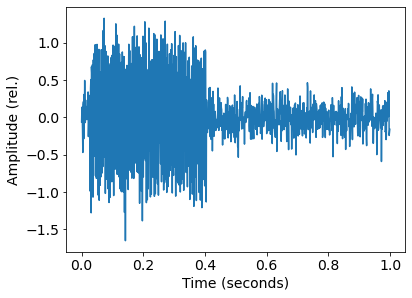

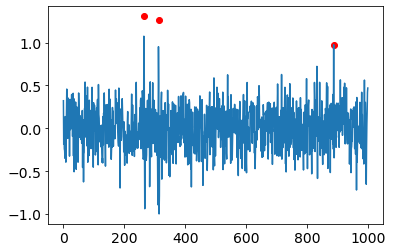

In [57]:
# # Sanity check
import matplotlib as mpl
font = {'size'   : 14}

mpl.rc('font', **font)

sumtest = np.nansum(input_matrix, axis=(1,2))
plt.plot(sumtest/(nF*(nL+1)))
plt.ylabel('Mean Spectral Power (dB)')
plt.show()

#fish example
it = 86
input_matrix = data[0]
fig1 = plt.figure(figsize=(7.5,4.5))
#plt.tight_layout()
plt.imshow(input_matrix[it,:,:], aspect='auto', origin='upper',cmap='jet',extent=[T2[0],T2[-1],F2[-1],F2[0]])
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (seconds)')
plt.gca().invert_yaxis()
cbar=plt.colorbar()
cbar.ax.set_title('decibels',size=14)
#plt.clim((0,1))

plt.savefig('Fish_Call_Spectrogram.png',bbox_inches='tight',facecolor='w')
plt.show()

fig2 = plt.figure(figsize=(6.075,4.5))
plt.tight_layout()
x = save_out['xn'][it]
t = save_out['t'][it]
plt.plot(t,x)
plt.ylabel('Amplitude (rel.)')
plt.xlabel('Time (seconds)')
#plt.gca().invert_yaxis()
#cbar=plt.colorbar()
#cbar.ax.set_title('decibels')
#plt.clim((0,1))
fig2.savefig('Fish_Call_Timeseries',bbox_inches='tight',facecolor='w')
plt.show()

# whale example
it = np.where(true_labels[0]==0.)[0]
it = it[2]
print(it)
input_matrix = data[0]
fig1 = plt.figure(figsize=(7.5,4.5))
#plt.tight_layout()
plt.imshow(input_matrix[it,:,:], aspect='auto', origin='upper',cmap='jet',extent=[T2[0],T2[-1],F2[-1],F2[0]])
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (seconds)')
plt.gca().invert_yaxis()
cbar=plt.colorbar()
cbar.ax.set_title('decibels',size=14)
#plt.clim((0,1))

plt.savefig('Whale_Call_Spectrogram.png',bbox_inches='tight',facecolor='w')
plt.show()

fig2 = plt.figure(figsize=(6.075,4.5))
plt.tight_layout()
x = save_out['xn'][it]
t = save_out['t'][it]
plt.plot(t,x)
plt.ylabel('Amplitude (rel.)')
plt.xlabel('Time (seconds)')
#plt.gca().invert_yaxis()
#cbar=plt.colorbar()
#cbar.ax.set_title('decibels')
#plt.clim((0,1))
fig2.savefig('Whale_Call_Timeseries',bbox_inches='tight',facecolor='w')
plt.show()


plt.plot(xn)
#plt.plot(hil)
plt.scatter(pks, hil[pks], c='r')
plt.show()



## Run the deep encoder

In [264]:
# # preallocate & set parameters # #
scores = dict()
scores['acc'] = []
scores['mutual_info'] = []
scores['silhouette'] = []
CAE = []
DEC_labels = []
encode_DEC = []

# define percent for training data
Ntot = input_matrix.shape[0]
Ntrain = np.floor(1*Ntot).astype(int)
Nval = np.floor(0*Ntot).astype(int)

## Set DEC parameters
# Parameters for the  DEC finetuning
batch_size=256    # number of samples in each batch
tol = 0.00001     # tolerance threshold to stop training
maxiter = 20*np.floor(Ntrain/batch_size).astype(int)#47250   # number of updates to rub before halting. (~12 epochs)
update_interval = np.floor(Ntrain/batch_size/2).astype(int)# Soft assignment distribution and target distributions updated evey 315 batches. 
                                   #(~2 updates/epoch)
pre_epochs = 1000#npretrain_list[M]

# # !!!!CPU SPECS # # ( won't work well but test to run )
batch_size = 32
update_interval = np.floor(Ntrain/batch_size/2).astype(int)
maxiter = 5*np.floor(Ntrain/batch_size).astype(int)
pre_epochs = 1000 # Takes ~1min on 2015 Macbook Pro

In [265]:
for M in range(Ntrials):
    #print('Running model for compression with dimension ' + str(ndim_list[M]) + '.')
   # print('Running model for ' + str(nclus_list[M]) + ' clusters.')
    t0=time.time()
    
    #--------------------------------------------------------------------------------------------------------------------
    # # Divide into train, val, and test data (randomly)
    import warnings

    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler(with_mean=False)
    #for M in range(Ntrials):
    input_matrix = data[0]


    t0=time.time()
    # split the data
    rng(3) # # fix or vary seed
    trainvalsplit=rd.permutation(Ntot)

    # # # train
    trainind = trainvalsplit[0:Ntrain]
    train = input_matrix[trainind,:,:, np.newaxis]
    tmin = np.min(train,axis=(0,1,2))
    tmax = np.max(train-tmin, axis=(0,1,2))
    train = (train-tmin)/tmax
    
    save_out['tmin'] = tmin
    save_out['tmax'] = tmax
    #train = scaler.fit_transform( input_matrix[trainind,:].reshape(Ntrain,-1) ).reshape(Ntrain,nF,nL+1,1)
    
    # # # val
    valind = trainvalsplit[Ntrain:(Ntrain+Nval)]
    val = input_matrix[valind,:,:,np.newaxis]
    val = (val-tmin)/tmax
  #  val = scaler.transform( input_matrix[valind,:,:].reshape(Nval,-1) ).reshape(Nval, nF, nL+1,1)

    # # # test
    testind = trainvalsplit[(Ntrain+Nval):(Ntrain+2*Nval)]
    test = input_matrix[testind,:,:,np.newaxis]
    test = (test-tmin)/tmax
   # test = scaler.transform( input_matrix[testind,:,:].reshape(Nval,-1) ).reshape(Nval, nF, nL+1,1)

    # normalize full data
    in_norm = input_matrix[:,:,:,np.newaxis]
    in_norm = (in_norm-tmin)/tmax
    #scaler.transform(input_matrix.reshape(Nsamp,-1)).reshape(Nsamp, nF, nL+1, 1)
    
    #print(train.shape, val.shape, test.shape)

    n_clusters=2 # dummy
    from tensorflow import set_random_seed
    rng(2)
    set_random_seed(2)
    # lines to reload in case of changes & to reset model
    import DEC_CAE_256nfft
    importlib.reload(DEC_CAE_256nfft)

    from DEC_CAE_256nfft import CAE_for_DEC
    models = CAE_for_DEC(nF, nL+1, 1,ndim_list[M], n_clusters)
    ae = models[0]
    encoder = models[1]
    
 
    #print(rd.randint(5,high=None)) # # checking randomness

    # PRETRAIN CAE
    print('Training CAE...')
    bc = (np.ceil(np.log2(np.abs(train.shape[0]/4)))).astype(int)
    t1=time.time()
    history1=ae.fit(train, train,
                    epochs=pre_epochs,
                    batch_size=2**bc,
                    shuffle=True,
                    validation_data=(val, val),
                    verbose=0,
                    callbacks= [TensorBoard(log_dir='/tmp/autoencoder')])
    print("{:.4} seconds.".format(time.time()-t1))
    decoded_imgs = ae.predict(in_norm)
    CAE_encoded = encoder.predict(in_norm)
    CAE_train_encoded = encoder.predict(train)
    
    #ae.save('AE_sim.h5')
    #encoder.save('enc_sim.h5')
    #ae.summary()
    
    CAE.append(CAE_encoded)
    

    #test_decode = ae.predict(in_norm)
    evalu = ae.evaluate(in_norm, in_norm)
    print(evalu)

    # Make DEC model
    loss = 0                           # initialize loss
    index = 0                          # initialize index to start 

    # # use GMM instead...
    from sklearn import mixture
    rng(3)
    g = mixture.GaussianMixture(n_components=2, covariance_type='diag')
    g.fit(CAE_train_encoded)
    labels = g.predict(CAE_train_encoded)
    labels_last = labels
    means = g.means_
    
    n_clusters=nclus_list[0]
    from tensorflow import set_random_seed
    rng(2)
    set_random_seed(2)
    import DEC_base
    importlib.reload(DEC_base) # adjusts for if the file was changed
    from DEC_base import DEC
    dec = DEC(n_clusters, g.weights_, ae, encoder) # uses trained model

    print('Getting initial clusters...')
    # # Initialize with K-means
    kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=2) # run kmeans with n_clusters, run 10 initializations to ensure accuracy
    labels = kmeans.fit_predict(CAE_train_encoded)             # get initial assignments
    klabels = labels
    #print(np.sum(klabels==np.array(true_labels)[0,trainind])/Ntrain) # accuracy
    labels_last=labels
    means = kmeans.cluster_centers_
    
     
    # initialize the DEC clustering layer weights using cluster centers found initally by kmeans.                                                                         
    dec.get_layer(name='clustering').set_weights([means])#[centroids])#

    print('Fine-tuning with DEC...')
    index_array = np.arange(train.shape[0])
    #https://github.com/dsnover/Unsupervised_Machine_Learning_for_Urban_Seismic_Noise/blob/master/CAE_wDEC.ipynb
    ###############################################################################
    ### simultaneous optimization and clustering
    loss_list = np.zeros([maxiter,3])                       # Keep track of loss function during training process
    for ite in range(int(maxiter)):
        if ite % update_interval == 0:
            q, reconst  = dec.predict(train, verbose=0) # Calculate soft assignment distribtuion & CAE reconstructions
            p = target_distribution(q)                      # Update the auxiliary target distribution p       
            labels = q.argmax(1)                            # Assign labels to the embedded latent space samples

            # check stop criterion - Calculate the % of labels that changed from previous update
            warnings.simplefilter(action='ignore', category=DeprecationWarning) # # #DUE TO MY PY/NUMPY VERSIONING
            delta_label = (np.sum(labels.astype(int) != labels_last.astype(int))).astype(np.float32) /labels.shape[0]  
            labels_last = np.copy(labels)                   # Generate copy of labels for future updates   
            loss= np.round(loss, 5)                         # Round the loss 

           # print('Iter %d' % ite)
           # print('Loss: {}'.format(loss))

            if ite > 0 and delta_label < tol:               # Break training if loss reaches the tolerance threshhold
                print('delta_label ', delta_label, '< tol ', tol)
                break
        
        idx = index_array[index * batch_size: min((index+1) * batch_size, train.shape[0])]
        loss = dec.train_on_batch(x=train[idx,:,:,:], y=[p[idx], train[idx,:,:,:]])
        index = index + 1 if (index + 1) * batch_size <= train.shape[0] else 0

    #dec.save(fname + str(ndim) + 'd_' + str(n_clusters) + 'c.hdf5')#.format(date_name))

    toc = time.time()
    print('Deep Embedded Clustering Computation Time : {0:4.1f} minutes'.format((toc-t0)/60))
    rng(2)
    set_random_seed(2)
    
    q, reconst  = dec.predict(in_norm) 
    decpred = encoder.predict(in_norm)
    encode_DEC.append(decpred)
    DEC_labels.append(q.argmax(1))
    
    DEC_labels_new = np.array(multiclass_accuracy(DEC_labels[M],true_labels[0]))
    DEC_labels[M] = DEC_labels_new.astype(int)
    
    if M==0:
        dec.summary()
    
    a1 = np.sum(DEC_labels[M]==true_labels[0])/Nsamp
    a2 = np.sum(np.abs(1-DEC_labels[M])==true_labels[0])/Nsamp
    
    acc = np.round(100*np.maximum(a1,a2),1)
    mi = metrics.normalized_mutual_info_score(true_labels[0], DEC_labels[M])
    if len(np.unique(DEC_labels[M]))>1:
        sil = metrics.silhouette_score(decpred, DEC_labels[M], metric='euclidean')
    else:
        sil = np.nan
    

    scores['acc'].append(acc)
    scores['mutual_info'].append(mi)
    scores['silhouette'].append(sil)
    
    print('Accuracy was ' + str(acc) + '%.')
    print('Mutual info: ' + str(mi) + '.')
    print('Silhouette score: ' + str(sil) + '.')

Training CAE...
139.0 seconds.
100/100 [==============================] - 1s 7ms/step
0.003962878752499819
Getting initial clusters...
Fine-tuning with DEC...
delta_label  0.0 < tol  1e-05
Deep Embedded Clustering Computation Time :  2.9 minutes
[0 1]
[42, 8] 0
[0, 50] 0
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 90, 20, 1)    0                                            
__________________________________________________________________________________________________
conv2d_358 (Conv2D)             (None, 45, 10, 8)    80          input[0][0]                      
__________________________________________________________________________________________________
conv2d_359 (Conv2D)             (None, 44, 10, 8)    136         conv2d_358[0][0]                 
___________________________________

[0.52267868 0.47732132]


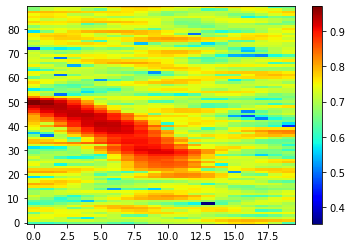

(100, 90, 20, 1)


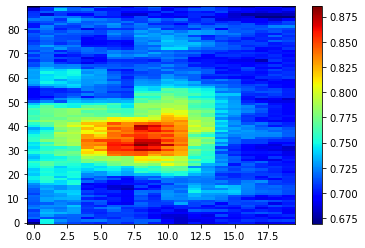

In [267]:
print(g.weights_)

it = 30
input_matrix = data[0]
plt.imshow(in_norm[it,:,:,0], aspect='auto', origin=-1,cmap='jet')
plt.colorbar()
#plt.clim((0,1))
plt.show()

print(reconst.shape)

# plot CAE reconstruction

plt.imshow(decoded_imgs[it,:,:,0], aspect='auto',origin=-1,cmap='jet')
#plt.clim((0,1))
plt.colorbar()
plt.show()

In [278]:
# t-SNE #
t0=time.time()

from sklearn.manifold import TSNE
#tsne = TSNE(perplexity=200)

# # CPU !! # #
tsne = TSNE(perplexity=20)

#Yd = tsne.fit_transform(CAE_train_encoded)
Ycae = tsne.fit_transform(CAE_encoded)
Ydec = tsne.fit_transform(encode_DEC[0])

print(time.time()-t0)

1.0911149978637695


In [100]:
# # # SAVE RELEVANT RESULTS
savename = 'Nov23_variable_256nfft_1000epochs_20epochs_10dim_2classes_2575'

save_out['seeds'] = seeds_all[iex,0]
save_out['spect_inputs'] = in_norm#[iex]
save_out['CAE_recon'] = decoded_imgs#[iex]
save_out['DEC_recon'] = reconst#[iex]
save_out['true_labels'] = true_labels[-1]
#save_out['agglom_CAE'] = h_labels[-1]
#ave_out['kmeans_CAE'] = y_labels[-1]
save_out['DEC_labels'] = DEC_labels[-1]
save_out['tsne_CAE'] = Ycae
save_out['tsne_DEC'] = Ydec
save_out['physical'] = pfeatures
save_out['snr_whale']=snrdb_whale_list
save_out['snr_fish'] = snrdb_fish_list

if False: # save
    sio.savemat(savename + '.mat', save_out)

In [38]:
savename_tuning = 'Nov9_variable_256nfft_1000epochs_20epochs_2class_ndims'

scores['nclus']= 2#nclus_list
scores['ndim'] = ndim_list
scores['ntrain'] = 1000#npretrain_list

if False: ## save
    sio.savemat(savename_tuning, scores)

[42, 8] 0
[0, 50] 0


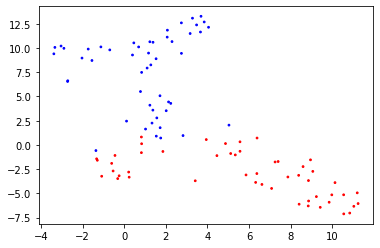

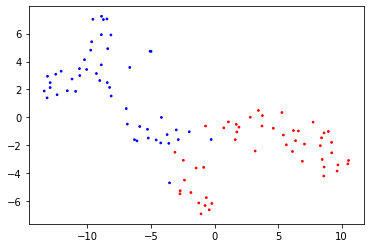

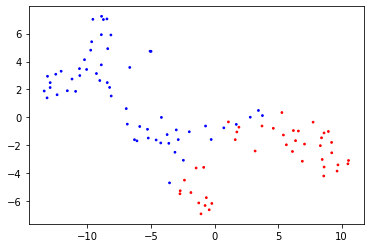

0.92
0.42


In [283]:
# scatterplot t-SNE
# # add agglomerative
h_labels = []
y_labels = []
Ntrials=1
for ii in range(Ntrials):
    CAE_encoded = CAE[ii]
    agglom = AgglomerativeClustering(n_clusters=n_clusters)
    h_labels.append(agglom.fit_predict(CAE_encoded))
   # y_labels.append(kmeans.fit_predict(CAE_encoded))#agglom.fit_predict(encode_DEC[0]))
    
DEC_labels = []
DEC_labels.append(q.argmax(1))

DEC_labels_new = np.array(multiclass_accuracy(DEC_labels[0],true_labels[0]))
DEC_labels[-1] = DEC_labels_new.astype(int)

refcol = ['r','b','k']
#caecolors = [refcol[y_labels[0][i]] for i in range(Nsamp)]
deccolors = [refcol[DEC_labels[-1][j]] for j in range(Nsamp)]
floatcolors = np.array([np.array((q[i,0],0,q[i,1])) for i in range(len(q))])
rt = true_labels[0].astype(int)
truecolors = [refcol[rt[j]] for j in range(Nsamp)]

plt.scatter(Ycae[:,0], Ycae[:,1],c=truecolors,s=3)
plt.show()

plt.scatter(Ydec[:,0], Ydec[:,1],c=truecolors,s=3)
plt.show()

plt.scatter(Ydec[:,0], Ydec[:,1],c=deccolors,s=3)
plt.show()

#print(len(DEC_labels))
print(np.sum(DEC_labels[-1]==true_labels[0])/Nsamp)
print(len(DEC_labels[-1][DEC_labels[-1]==0])/Nsamp)

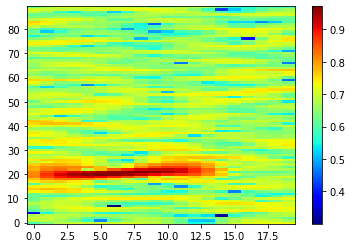

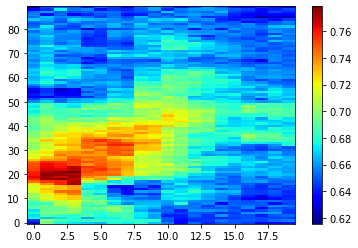

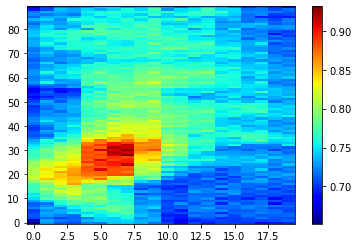

In [285]:
it = 21
input_matrix = data[0]
plt.imshow(in_norm[it,:,:,0], aspect='auto', origin=-1,cmap='jet')
plt.colorbar()
#plt.clim((0,1))
plt.show()

plt.imshow(decoded_imgs[it,:,:,0], aspect='auto',origin=-1,cmap='jet')
#plt.clim((0,1))
plt.colorbar()
plt.show()

plt.imshow(reconst[it,:,:,0], aspect='auto',origin=-1,cmap='jet')
#plt.clim((0,1))
plt.colorbar()
plt.show()
